# Benchmarking Retrievers

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import time
import torch
import voyageai
import wikipedia
from bs4 import BeautifulSoup
from gritlm import GritLM
from sentence_transformers import SentenceTransformer, util
from math import log2
from tqdm import tqdm
from urllib.request import urlopen

In [2]:
def fix_random_seeds(seed):
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

fix_random_seeds(42)

In [3]:
sns.set_style('darkgrid')
sns.set(font_scale=1.4)
plt.rcParams['font.family'] = 'Serif'

In [4]:
filepaths_benchmark = []
filepaths_metrics = []
directory_benchmark = 'retrievers_benchmark'
directory_metrics = 'retrievers_metrics'

for filename in os.listdir(directory_benchmark):
    f_benchmark = os.path.join(directory_benchmark, filename)
    f_metrics = os.path.join(directory_metrics, filename)
    filepaths_benchmark.append(f_benchmark)
    filepaths_metrics.append(f_metrics)

filepaths_benchmark = sorted(filepaths_benchmark)
filepaths_metrics = sorted(filepaths_metrics)

In [5]:
mapping = {
    0.0: 0,
    1.0: 1,
    2.1: 2,
    2.2: 3,
    2.3: 4,
    3.0: 5
}

mapping_binary = {
    0.0: 0,
    1.0: 0,
    2.1: 0,
    2.2: 0,
    2.3: 1,
    3.0: 1
}

for filepath in filepaths_benchmark:
    df = pd.read_csv(filepath)
    df['Relevance Score'] = df['Annotation'].map(mapping)
    df['Binary Relevance Score'] = df['Annotation'].map(mapping_binary)
    df['BM25 Rank'] = df.index + 1
    df.to_csv(filepath, index=False)

## Metric: Normalized Discounted Cumulative Gain (NDCG@K)

In [6]:
def ndcg(relevance_scores):
    ideal_relevance_scores = sorted(relevance_scores, reverse=True)

    dcg = 0
    idcg = 0
    ndcg = []

    for k in range(1, len(relevance_scores) + 1):
        rel_k = relevance_scores[k-1]
        ideal_rel_k = ideal_relevance_scores[k-1]
        dcg += rel_k / log2(k + 1)
        idcg += ideal_rel_k / log2(k + 1)
        ndcg.append(dcg / idcg)

    return ndcg

## The Only Language-Agnostic Ranker (aka Baseline): BM25

In [7]:
for i, f_benchmark in enumerate(filepaths_benchmark):
    df_benchmark = pd.read_csv(f_benchmark)
    df_metrics = pd.read_csv(filepaths_metrics[i])
    df_metrics['BM25 Paragraphs'] = df_benchmark['Paragraph']
    df_metrics['BM25 Relevance Score'] = df_benchmark['Relevance Score']
    df_metrics['BM25 NDCG@K'] = ndcg(df_benchmark['Relevance Score'])
    df_metrics.to_csv(filepaths_metrics[i], index=False)

## Wikipedia Summary as Query

In [8]:
def get_query(term, language):
    soup = BeautifulSoup(urlopen('http://en.wikipedia.org/wiki/' + (term[:1].upper() + term[1:]).replace(' ', '_')), features="lxml")
    interwikihead = soup.find('li', class_=('interlanguage-link interwiki-' + language + ' mw-list-item'))

    try:
        if language == 'en':
            title = term[:1].upper() + term[1:]
        else:
            title = interwikihead.a.get('title').split(u' – ')[0]
        wikipedia.set_lang(language)
        page = wikipedia.page(title, auto_suggest=False)
        return page.summary
    except:
        return None

In [9]:
query = get_query('Word order', 'en')
query

'In linguistics, word order (also known as linear order) is the order of the syntactic constituents of a language. Word order typology studies it from a cross-linguistic perspective, and examines how languages employ different orders. Correlations between orders found in different syntactic sub-domains are also of interest. The primary word orders that are of interest are\n\nthe constituent order of a clause, namely the relative order of subject, object, and verb;\nthe order of modifiers (adjectives, numerals, demonstratives, possessives, and adjuncts) in a noun phrase;\nthe order of adverbials.\nSome languages use relatively fixed word order, often relying on the order of constituents to convey grammatical information. Other languages—often those that convey grammatical information through inflection—allow more flexible word order, which can be used to encode pragmatic information, such as topicalisation or focus. However, even languages with flexible word order have a preferred or ba

## Embeddings

https://huggingface.co/spaces/mteb/leaderboard

Retrieval English Leaderboard 🔎

Metric: Normalized Discounted Cumulative Gain @ k (ndcg_at_10)

### MTEB #1: SFR-Embedding-Mistral

In [ ]:
model = SentenceTransformer('Salesforce/SFR-Embedding-Mistral')
model.eval();

In [10]:
def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'

def get_scores_on_batch(query_embedding, documents, model):
    with torch.no_grad():
        documents_embeddings = model.encode(documents)
        scores = util.cos_sim(query_embedding, documents_embeddings) * 100
        return scores.detach().cpu().tolist()[0]

In [11]:
def rerank_and_save(model_name, cos_sim_scores, df, df_output_filepath):
    order = sorted(range(len(cos_sim_scores)), key=lambda i: cos_sim_scores[i], reverse=True)
    reranked_cos_sim_scores = [cos_sim_scores[i] for i in order]
    reranked_relevance_scores = [df['Relevance Score'][i] for i in order]
    reranked_paragraphs = [df['Paragraph'][i] for i in order]
    ndcg_scores = ndcg(reranked_relevance_scores)
    df_metrics = pd.read_csv(df_output_filepath)
    df_metrics[f'{model_name} Paragraphs'] = reranked_paragraphs
    df_metrics[f'{model_name} Cosine Similarity'] = reranked_cos_sim_scores
    df_metrics[f'{model_name} Relevance Score'] = reranked_relevance_scores
    df_metrics[f'{model_name} NDCG@K'] = ndcg_scores
    df_metrics.to_csv(df_output_filepath, index=False)

In [12]:
default_instruct = 'Given a web search query, retrieve relevant passages that answer the query'
specific_instruct = 'Given a definition of a linguistic feature, retrieve relevant passages that let a linguist unambiguously determine the value of this feature in the described language'

In [13]:
def get_ndcg_on_dataset(query, model, model_name, instruct=None):
    if instruct == None:
        query_embedding = model.encode([query])
    else:
        query_embedding = model.encode([get_detailed_instruct(instruct, query)])
    for i, f_benchmark in enumerate(filepaths_benchmark):
        df = pd.read_csv(f_benchmark)
        cos_sim_scores = []
        for k in tqdm(range(0, 50), desc=f'Processing file {i + 1}', ncols=100):
            cos_sim_scores.extend(get_scores_on_batch(query_embedding, [df['Paragraph'][k]], model))
        rerank_and_save(model_name, cos_sim_scores, df, filepaths_metrics[i])

In [15]:
get_ndcg_on_dataset(query, model, 'SFR-Embedding-Mistral Default Instruct', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


In [16]:
get_ndcg_on_dataset(query, model, 'SFR-Embedding-Mistral Specific Instruct', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


### MTEB #2: voyage-large-2-instruct

In [14]:
def get_ndcg_on_dataset_voyageai(query, model_name):
    vo = voyageai.Client(api_key='pa-iAxI6SVpBqzmfn7g4ri5nH7CMbde2Cx0G1P6zSX4dkE')
    query_embedding = vo.embed(
        [query], 
        model='voyage-large-2-instruct', 
        input_type='query'
    ).embeddings
    for i, f_benchmark in enumerate(filepaths_benchmark):
        df = pd.read_csv(f_benchmark)
        documents_embeddings = []
        documents = list(df['Paragraph'])
        if i == 4:
            batch_size = 1
        else:
            batch_size = 2
        for k in tqdm(
            range(0, len(documents), batch_size), 
            desc=f'Processing file {i + 1}',
            ncols=100
        ):
            documents_embeddings.extend(
                vo.embed(
                    documents[k:k+batch_size],
                    model='voyage-large-2-instruct', 
                    input_type='document'
                ).embeddings
            )
            time.sleep(60)
        cos_sim_scores = (util.cos_sim(query_embedding, documents_embeddings) * 100).tolist()[0]
        rerank_and_save(model_name, cos_sim_scores, df, filepaths_metrics[i])

In [15]:
get_ndcg_on_dataset_voyageai(query, 'voyage-large-2-instruct')

Processing file 14: 100%|███████████████████████████████████████████| 25/25 [25:21<00:00, 60.86s/it]


### MTEB #3: gte-large-en-v1.5

In [14]:
model = SentenceTransformer('Alibaba-NLP/gte-large-en-v1.5', trust_remote_code=True)

/home/jovyan/.mlspace/envs/albert_rl/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/jovyan/.mlspace/envs/albert_rl/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:
get_ndcg_on_dataset(query, model, 'gte-large-en-v1.5')

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 36.60it/s]


### MTEB #4: GritLM-7B

In [ ]:
model = GritLM('GritLM/GritLM-7B', mode='embedding', torch_dtype='auto')

In [ ]:
def gritlm_instruction(instruction):
    return '<|user|>\n' + instruction + '\n<|embed|>\n' if instruction else '<|embed|>\n'

In [ ]:
def get_ndcg_on_dataset_gritlm(query, model, model_name, instruct):
    query_embedding = model.encode([query], instruction=gritlm_instruction(instruct))
    for i, f_benchmark in enumerate(filepaths_benchmark):
        df = pd.read_csv(f_benchmark)
        cos_sim_scores = []
        for k in tqdm(range(0, 50), desc=f'Processing file {i + 1}', ncols=100):
            document_embedding = model.encode([df['Paragraph'][k]], instruction=gritlm_instruction(''))
            cos_sim_scores.extend((util.cos_sim(query_embedding, document_embedding) * 100).tolist()[0])
        rerank_and_save(model_name, cos_sim_scores, df, filepaths_metrics[i])

In [ ]:
get_ndcg_on_dataset_gritlm(query, model, 'GritLM-7B Default Instruct', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 27.29it/s]


In [ ]:
get_ndcg_on_dataset_gritlm(query, model, 'GritLM-7B Specific Instruct', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 27.26it/s]


### MTEB #5: e5-mistral-7b-instruct

In [14]:
model = SentenceTransformer('intfloat/e5-mistral-7b-instruct')

/home/jovyan/.mlspace/envs/albert_rl/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/jovyan/.mlspace/envs/albert_rl/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:
model.max_seq_length = 4096

In [16]:
get_ndcg_on_dataset(query, model, 'e5-mistral-7b-instruct Default Instruct', default_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


In [17]:
get_ndcg_on_dataset(query, model, 'e5-mistral-7b-instruct Specific Instruct', specific_instruct)

Processing file 14: 100%|███████████████████████████████████████████| 50/50 [00:15<00:00,  3.26it/s]


### Plots

In [32]:
filepaths_benchmark = []
filepaths_metrics = []
filepaths_metrics_old = []
directory_benchmark = 'retrievers_benchmark'
directory_metrics = 'retrievers_metrics'
directory_metrics_old = 'retrievers_metrics_old'

for filename in os.listdir(directory_benchmark):
    f_benchmark = os.path.join(directory_benchmark, filename)
    f_metrics = os.path.join(directory_metrics, filename)
    f_metrics_old = os.path.join(directory_metrics_old, filename)
    filepaths_benchmark.append(f_benchmark)
    filepaths_metrics.append(f_metrics)
    filepaths_metrics_old.append(f_metrics_old)

filepaths_metrics = sorted(filepaths_metrics)
filepaths_metrics_old = sorted(filepaths_metrics_old)

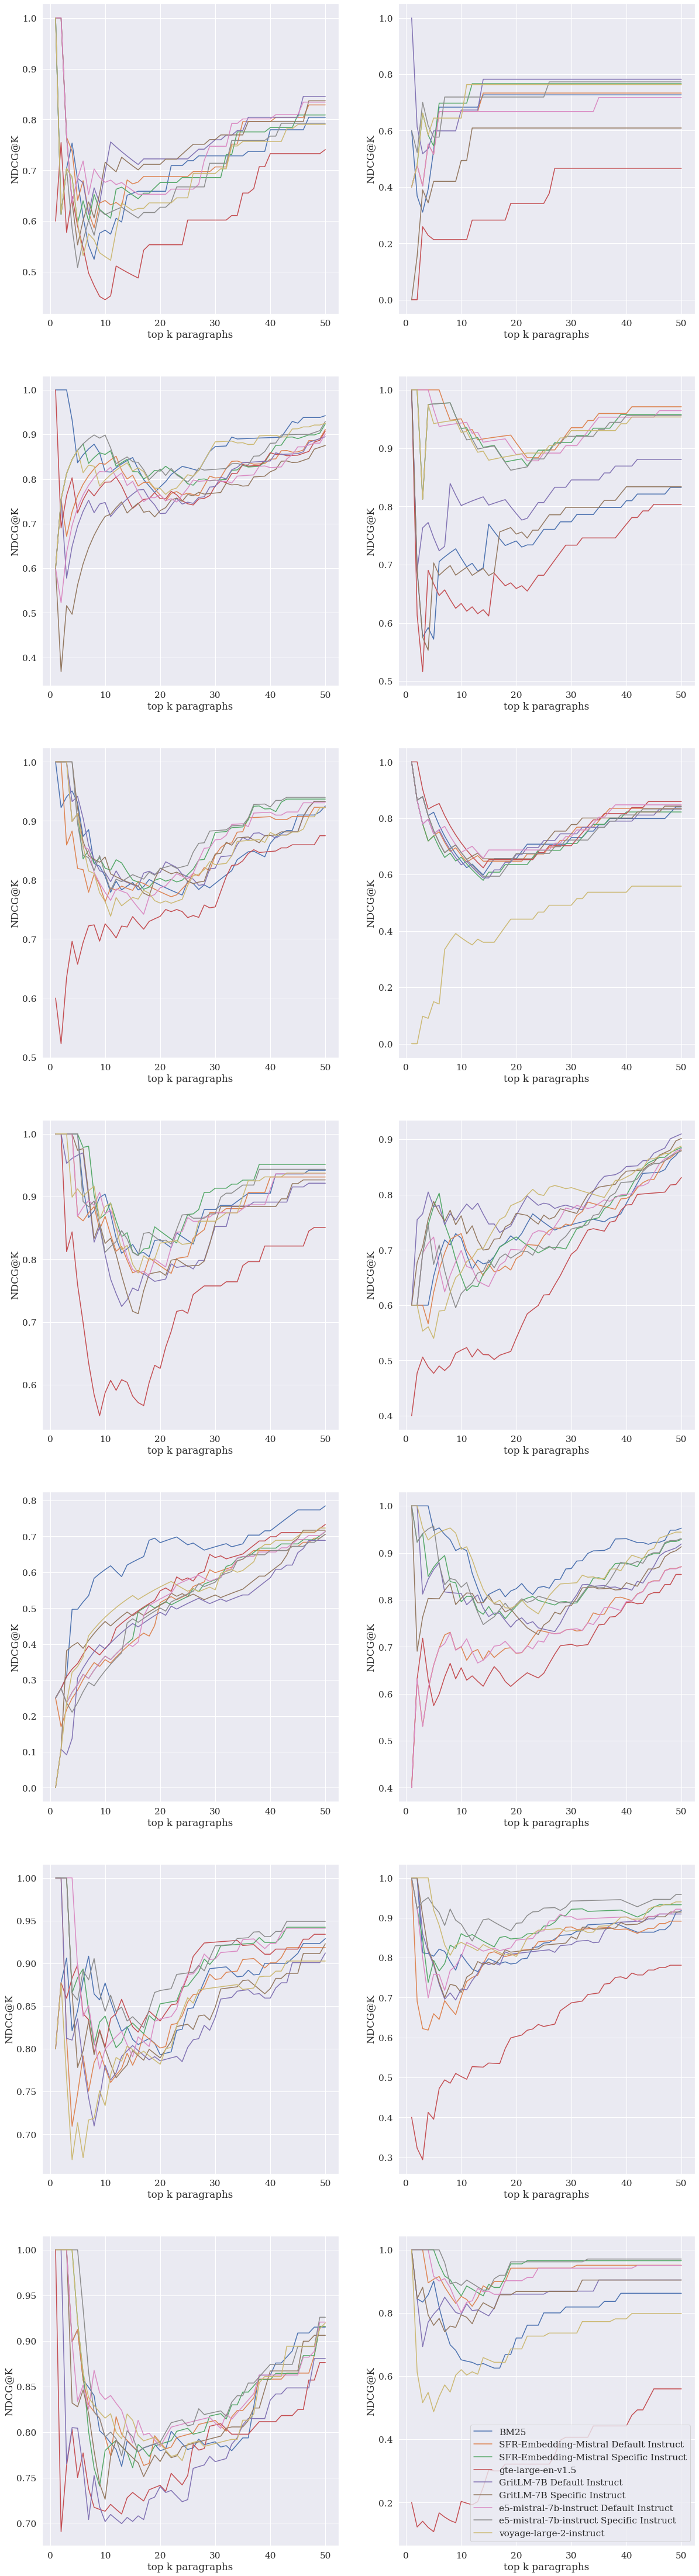

In [16]:
x = range(1, 51)
plt.rcParams['figure.figsize'] = (20, 80)
fig, axs = plt.subplots(7, 2)
for i in range(7):
    for j in range(2):
        df = pd.read_csv(filepaths_metrics[i * 2 + j])
        for column in df.columns:
            if 'NDCG@K' in column:
                axs[i, j].plot(x, df[column], label = column[:-7])
                axs[i, j].set_xlabel('top k paragraphs')
                axs[i, j].set_ylabel('NDCG@K')
plt.legend()
plt.show()